In [2]:
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path.home()/ "Desktop" / "Insurance_Project"
os.chdir(PROJECT_ROOT)

print(os.getcwd())

C:\Users\phili\Desktop\Insurance_Project


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from src.models import clustering as c
import importlib


In [4]:
import joblib

In [5]:
from src.data import preprocessing as pr
data = c.load_data(PROJECT_ROOT/"dashboard"/"assets"/"dashboard_data.csv")

In [6]:
data.head(5)

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,incident_city,incident_location,witnesses,total_claim_amount,auto_make,auto_model,auto_year,month_sin,month_cos,severe
0,328,48.0,OH,250/500,1000.0,1406.91,0.0,466132,MALE,MD,...,Columbus,9935 4th Drive,2.0,71610.0,Saab,92x,2004.0,-8.660254e-01,5.000000e-01,0
1,228,42.0,IN,250/500,2000.0,1197.22,5000000.0,468176,MALE,MD,...,Riverwood,6608 MLK Hwy,0.0,5070.0,Mercedes,E400,2007.0,1.224647e-16,-1.000000e+00,0
2,134,29.0,OH,100/300,2000.0,1413.14,5000000.0,430632,FEMALE,PhD,...,Columbus,7121 Francis Lane,3.0,34650.0,Dodge,RAM,2007.0,-1.000000e+00,-1.836970e-16,0
3,256,41.0,IL,250/500,2000.0,1415.74,6000000.0,608117,FEMALE,PhD,...,Arlington,6956 Maple Drive,2.0,63400.0,Chevrolet,Tahoe,2014.0,5.000000e-01,-8.660254e-01,0
4,228,44.0,IL,500/1000,1000.0,1583.91,6000000.0,610706,MALE,Associate,...,Arlington,3041 3rd Ave,1.0,6500.0,Accura,RSX,2009.0,1.224647e-16,-1.000000e+00,0


In [7]:
numerical_columns = data.select_dtypes(include='number').columns# type: ignore
ordinal_columns = ['policy_state','policy_csl','insured_sex', 'insured_education_level']
ordinal_categories = [['OH', 'IN', 'IL'],
                      ['100/300', '250/500', '500/1000'],
                      ['MALE', 'FEMALE'],
                      ['High School', 'Masters','JD', 'MD'],]
cat_cols = data.select_dtypes(include="object").columns# type: ignore
bool_cols = []
for col in data.columns:
    unique_vals = set(data[col].dropna().unique())
    if unique_vals.issubset({True, False}):
        data[col] = data[col].astype('boolean')  # nullable bool
        bool_cols.append(col)
cat_cols = [x for x in cat_cols if x not in bool_cols]
nominal_columns = [x for x in cat_cols if x not in ordinal_columns]

In [8]:
preprocessor, data_processed = pr.prepreprocessing_pipeline(
    X = data,
    numerical_cols=numerical_columns,
    ordinal_cols=ordinal_columns,
    ordinal_categories=ordinal_categories,
    nominal_cols=nominal_columns,
    bool_cols=bool_cols
)

In [9]:
print(data_processed.shape)
print(data.shape)

for col in data.columns:
    print(col)

(1000, 24)
(1000, 23)
months_as_customer
age
policy_state
policy_csl
policy_deductable
policy_annual_premium
umbrella_limit
insured_zip
insured_sex
insured_education_level
insured_occupation
insured_relationship
incident_state
incident_city
incident_location
witnesses
total_claim_amount
auto_make
auto_model
auto_year
month_sin
month_cos
severe


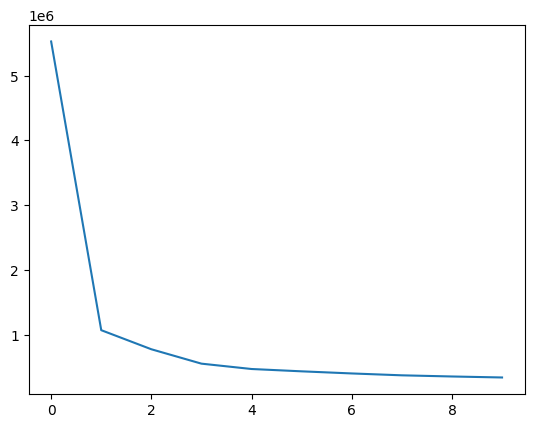

In [10]:
inertias = c.elbow_inertia(data_processed)
plt.plot(range(10),inertias)

In [11]:
elbow = 2

In [41]:
importlib.reload(c)


<module 'src.models.clustering' from 'C:\\Users\\phili\\Desktop\\Insurance_Project\\src\\models\\clustering.py'>

In [42]:
labels, model, sil = c.kmeans_cluster(data_processed)

In [43]:
labeled_data, centroids = c.kmeans_add_labels_and_cluster_centers(data, labels, numerical_columns)

In [44]:
labeled_data.head(5)

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,incident_location,witnesses,total_claim_amount,auto_make,auto_model,auto_year,month_sin,month_cos,severe,Cluster kmeans
0,328,48.0,OH,250/500,1000.0,1406.91,0.0,466132,MALE,MD,...,9935 4th Drive,2.0,71610.0,Saab,92x,2004.0,-8.660254e-01,5.000000e-01,False,0
1,228,42.0,IN,250/500,2000.0,1197.22,5000000.0,468176,MALE,MD,...,6608 MLK Hwy,0.0,5070.0,Mercedes,E400,2007.0,1.224647e-16,-1.000000e+00,False,1
2,134,29.0,OH,100/300,2000.0,1413.14,5000000.0,430632,FEMALE,PhD,...,7121 Francis Lane,3.0,34650.0,Dodge,RAM,2007.0,-1.000000e+00,-1.836970e-16,False,0
3,256,41.0,IL,250/500,2000.0,1415.74,6000000.0,608117,FEMALE,PhD,...,6956 Maple Drive,2.0,63400.0,Chevrolet,Tahoe,2014.0,5.000000e-01,-8.660254e-01,False,1
4,228,44.0,IL,500/1000,1000.0,1583.91,6000000.0,610706,MALE,Associate,...,3041 3rd Ave,1.0,6500.0,Accura,RSX,2009.0,1.224647e-16,-1.000000e+00,False,0


In [45]:
centroids

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,witnesses,total_claim_amount,auto_year,month_sin,month_cos,severe
Cluster kmeans,,,,,,,,,,,,
0,206.547455,39.059147,1135.488308,1255.692682,1.071527e+06,500439.229711,1.485557,53932.696011,2004.980743,0.012748,0.034928,0.206327
1,197.047619,38.652015,1137.362637,1258.306117,1.179487e+06,503279.003663,1.490842,49644.212454,2005.428571,-0.053245,-0.027341,0.186813


In [46]:
print("sil", sil)

sil 0.7224793839655174


In [47]:
labels, model, ep, min  = c.dbscan_clusters(data_processed)

In [48]:
db_scaned_data, db_centroids = c.kmeans_add_labels_and_cluster_centers(data, labels, numerical_columns)

In [49]:
db_scaned_data.head(5)

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,...,incident_location,witnesses,total_claim_amount,auto_make,auto_model,auto_year,month_sin,month_cos,severe,Cluster kmeans
0,328,48.0,OH,250/500,1000.0,1406.91,0.0,466132,MALE,MD,...,9935 4th Drive,2.0,71610.0,Saab,92x,2004.0,-8.660254e-01,5.000000e-01,False,0
1,228,42.0,IN,250/500,2000.0,1197.22,5000000.0,468176,MALE,MD,...,6608 MLK Hwy,0.0,5070.0,Mercedes,E400,2007.0,1.224647e-16,-1.000000e+00,False,-1
2,134,29.0,OH,100/300,2000.0,1413.14,5000000.0,430632,FEMALE,PhD,...,7121 Francis Lane,3.0,34650.0,Dodge,RAM,2007.0,-1.000000e+00,-1.836970e-16,False,-1
3,256,41.0,IL,250/500,2000.0,1415.74,6000000.0,608117,FEMALE,PhD,...,6956 Maple Drive,2.0,63400.0,Chevrolet,Tahoe,2014.0,5.000000e-01,-8.660254e-01,False,-1
4,228,44.0,IL,500/1000,1000.0,1583.91,6000000.0,610706,MALE,Associate,...,3041 3rd Ave,1.0,6500.0,Accura,RSX,2009.0,1.224647e-16,-1.000000e+00,False,-1


In [50]:
print(len(set(labels)))

3


In [51]:
outliers = [i for i in labels if i == -1]
print(len(outliers))

980


### Conclusion

KMeans outperforms DBSCAN when clustering the data. DBscan will fail to generalize and will either result in a clustering that is much to granular too analyse, or result in an inordinate amount of labeled outliers. My hypothesis is that this is due to the high dimensionality of the data. 

One solution could be to reduce dimensionality with feature selection and methods like PCA or t-SNE, while another could be to stick with KMEANS since it seems to produce more robust results when faced with high dimensional data. 

KMEANS will be regardes as our main approach for this project due to time constraints, and the relatively small marginal benefit from changing to DBSCAN.